Lets now look into regression.

Some of the examples are from [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). 

## Predicting house prices: A regression example

### The CAL Housing Price dataset

**Loading the California housing dataset**

In [5]:
from keras.datasets import california_housing

(train_data, train_targets), (test_data, test_targets) = (
    california_housing.load_data(version="small")
)

743530/743530 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [6]:
train_data[0]

array([-1.2224e+02,  3.7730e+01,  2.1000e+01,  7.0310e+03,  1.2490e+03,
        2.9300e+03,  1.2350e+03,  4.5213e+00], dtype=float32)

The variables are:

1. The longitude of the approximate geographic center of the area.
2. The latitude of the approximate geographic center of the area.
3. The median age of houses in the district.
4. The population of the district.
5. The total number of households.
6. The median income of those households.
7. The total number of rooms in the district, across all homes located there.
8. The total number of bedrooms in the district.

In [7]:
test_data.shape

(120, 8)

In [8]:
train_targets

array([228400., 132900.,  60000.,  95200., 107000., 122500., 132000.,
       290100., 257800., 390100., 220800., 284900.,  97500., 415300.,
        84200., 185600., 216700., 233100., 127000., 182300.,  92300.,
        90700., 102100., 112500., 350700., 156500., 220700., 147400.,
       216700., 275000., 198200., 119100., 289500., 152500., 125000.,
       104500.,  93800.,  89300., 452600., 128600., 311500.,  90000.,
       218200., 131300.,  67500., 139400., 500001., 182600., 111300.,
       112500., 134700.,  71300., 207400., 331400., 107900.,  87500.,
       342200.,  87100., 314700., 368600., 211600., 338900., 366100.,
       164300.,  91700., 261400., 218500., 155400., 273700.,  81800.,
       138800.,  99700., 156300., 140600., 152700., 108900., 351200.,
       126000., 137500., 196900., 240000., 172800., 254200.,  97500.,
       182700., 162500.,  86100., 226700., 412500., 165900., 327100.,
       162500., 188800., 183800.,  90600., 372000., 275000., 151800.,
       125000., 1291

### Preparing the data

**Normalizing the data**

feature-wise normalization!  
So that all the features have a less hectic ranges and are distributed around 0.

In [24]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
x_train = (train_data - mean) / std
x_test = (test_data - mean) / std

Remember not to use any values from processing the test data. The test data cannot influence the training data.

In [18]:
y_train = train_targets / 100000
y_test = test_targets / 100000

The bigger the outcome, the higher the weights needed to get there. With lower learning rates it takes a long time for the model to get there. We can simply scale the outputs (and then scale them back). It might be an easy fix for many of your cases.

### Building your model

**Model definition**

Small models - a way of preventing overfiting.  
Mse - a standard loss for a regression problem.

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np 
from matplotlib import pyplot as plt

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model

There is no activation function on the last layer as this would constrain the model into the (-1,1) value space. In this case the model can learn those higher values we need.

### Validating your approach using K-fold validation

**K-fold validation**

<img src="../img/k-fold.png" alt="K-Fold Validation" style="width:600px;"/>

In [35]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 50
all_scores = []

for i in range(k):
    print(f"Processing fold #{i + 1}")
    
    # Prepares the validation data: data from partition #k
    fold_x_val = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train[i * num_val_samples : (i + 1) * num_val_samples]

    # Prepares the training data: data from all other partitions
    fold_x_train = np.concatenate(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    fold_y_train = np.concatenate(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]],
        axis=0,
    )

    model = build_model()
    
    # Trains the model
    model.fit(
        fold_x_train,
        fold_y_train,
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )
    # Evaluates the model on the validation data
    scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    val_loss, val_mae = scores
    all_scores.append(val_mae)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [34]:
all_scores

[0.31750449538230896,
 0.298490047454834,
 0.2384212762117386,
 0.29615694284439087]

In [36]:
np.mean(all_scores)

np.float64(0.2837052121758461)

**Saving the validation logs at each fold**

In [37]:
k = 4
num_val_samples = len(x_train) // k
num_epochs = 200
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i + 1}")

    # Prepares the validation data: data from partition #k
    fold_x_val = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train[i * num_val_samples : (i + 1) * num_val_samples]

    # Prepares the training data: data from all other partitions
    fold_x_train = np.concatenate(
        [x_train[: i * num_val_samples], x_train[(i + 1) * num_val_samples :]],
        axis=0,
    )
    fold_y_train = np.concatenate(
        [y_train[: i * num_val_samples], y_train[(i + 1) * num_val_samples :]],
        axis=0,
    )

    model = build_model()
    
    # Trains the model
    history = model.fit(
        fold_x_train,
        fold_y_train,
        validation_data=(fold_x_val, fold_y_val),
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )
    mae_history = history.history["val_mean_absolute_error"]
    all_mae_histories.append(mae_history)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


**Building the history of successive mean K-fold validation scores**

In [38]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores**

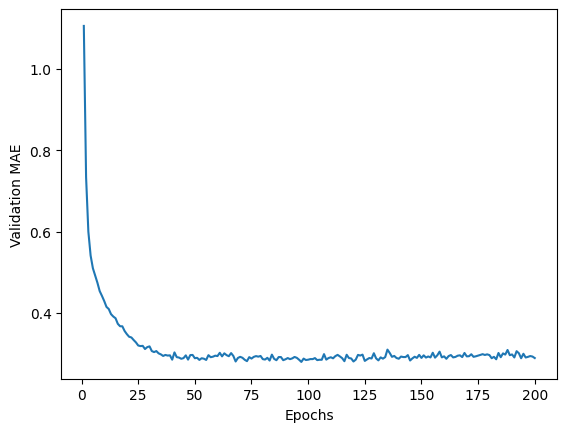

In [39]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

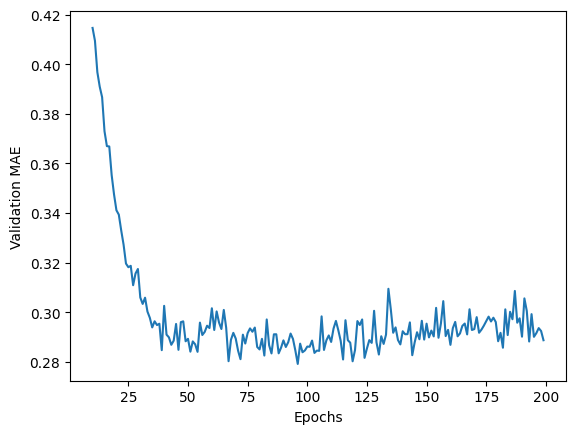

In [45]:
truncated_mae_history = average_mae_history[10:]
epochs = range(10, len(truncated_mae_history) + 10)
plt.plot(epochs, truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Training the final model**

In [50]:
model = build_model()
history = model.fit(x_train, y_train, epochs=130, batch_size=16, verbose=0)
test_mean_squared_error, test_mean_absolute_error = model.evaluate(
    x_test, y_test
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2985 - mean_absolute_error: 0.3074 


In [51]:
round(test_mean_absolute_error, 3)

0.307

In [52]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mean_absolute_error'])

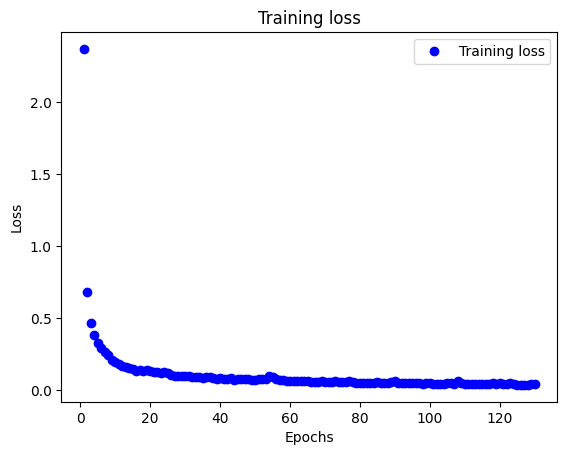

In [54]:
history_dict = history.history
loss_values = history_dict["loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Remember that when little training data is available, it’s better to use a small model (in layer and the whole network size) with few intermediate layers, in order to avoid severe overfitting.

### Generating predictions on new data

In [55]:
predictions = model.predict(test_data) * 100000
predictions[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([264603.94], dtype=float32)

In [56]:
test_targets[0]

np.float32(218800.0)